## Necessary dependancies

We will need the following packages:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html
- Gensim: https://radimrehurek.com/gensim/

All are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn

In [2]:
import os.path as op
import re 
import numpy as np
import matplotlib.pyplot as plt
import pprint
import sklearn
pp = pprint.PrettyPrinter(indent=3)

## Loading data

We retrieve data from the ```gensim``` API. We will use titles from the **fake-news** dataset: 

In [3]:
import gensim.downloader as api

In [4]:
pp.pprint(api.info("fake-news"))  # return dict with info about "fake-news" dataset
dataset = api.load("fake-news")

{  'checksum': '5e64e942df13219465927f92dcefd5fe',
   'description': 'News dataset, contains text and metadata from 244 websites '
                  'and represents 12,999 posts in total from a specific window '
                  'of 30 days. The data was pulled using the webhose.io API, '
                  "and because it's coming from their crawler, not all "
                  'websites identified by their BS Detector are present in '
                  'this dataset. Data sources that were missing a label were '
                  "simply assigned a label of 'bs'. There are (ostensibly) no "
                  'genuine, reliable, or trustworthy news sources represented '
                  "in this dataset (so far), so don't trust anything you read.",
   'fields': {  'author': 'author of story',
                'comments': 'number of Facebook comments',
                'country': 'data from webhose.io',
                'crawled': 'date the story was archived',
                'domain_ra

How to extract the data ? Let's look at the object: 

In [5]:
print(dataset.__dict__)
import pandas as pd
import gzip

{'fn': '/home/matthieu/gensim-data/fake-news/fake-news.gz'}


In [6]:
with gzip.open(dataset.fn, 'rb') as f:
    fakenews = pd.read_csv(f, na_filter=False)

print(fakenews.head())

                                       uuid  ord_in_thread  \
0  6a175f46bcd24d39b3e962ad0f29936721db70db              0   
1  2bdc29d12605ef9cf3f09f9875040a7113be5d5b              0   
2  c70e149fdd53de5e61c29281100b9de0ed268bc3              0   
3  7cf7c15731ac2a116dd7f629bd57ea468ed70284              0   
4  0206b54719c7e241ffe0ad4315b808290dbe6c0f              0   

                 author                      published  \
0     Barracuda Brigade  2016-10-26T21:41:00.000+03:00   
1  reasoning with facts  2016-10-29T08:47:11.259+03:00   
2     Barracuda Brigade  2016-10-31T01:41:49.479+02:00   
3                Fed Up  2016-11-01T05:22:00.000+02:00   
4                Fed Up  2016-11-01T21:56:00.000+02:00   

                                               title  \
0  Muslims BUSTED: They Stole Millions In Gov’t B...   
1  Re: Why Did Attorney General Loretta Lynch Ple...   
2  BREAKING: Weiner Cooperating With FBI On Hilla...   
3  PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...  

In [7]:
print(fakenews.columns.values)
texts = fakenews.loc[:,'title'].astype('str').tolist()

['uuid' 'ord_in_thread' 'author' 'published' 'title' 'text' 'language'
 'crawled' 'site_url' 'country' 'domain_rank' 'thread_title' 'spam_score'
 'main_img_url' 'replies_count' 'participants_count' 'likes' 'comments'
 'shares' 'type']


In [8]:
pp.pprint(texts[0])

'Muslims BUSTED: They Stole Millions In Gov’t Benefits'


## 1 - Topic Modeling of documents

In order to apply Topic modeling methods to this data, we will need a Term-document matrix (which will contains **Bag-of-words** representations of the documents)
We can begin by using the **CountVectorizer** class from scikit-learn to obtain these representations:

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']
vectorizer = CountVectorizer()

Bow = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names())
Bow.toarray()

['avenue', 'boulevard', 'city', 'down', 'ran', 'the', 'walk', 'walked']


/home/matthieu/anaconda3/envs/TPs_NLP_39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array([[0, 1, 0, 2, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 2, 1, 0]])

In [14]:
stop_words = sklearn.feature_extraction.text.ENGLISH_STOP_WORDS
print(stop_words)

frozenset({'next', 'hundred', 'becomes', 'be', 'her', 'very', 'bottom', 'most', 'thence', 'behind', 'towards', 'toward', 'our', 'perhaps', 'the', 'within', 'two', 'will', 'such', 'one', 'none', 'amount', 'an', 'put', 'a', 'else', 'because', 'became', 'couldnt', 'please', 'take', 'latter', 'un', 'how', 'along', 'twenty', 'whither', 'on', 'another', 'off', 'around', 'elsewhere', 'many', 'so', 'sixty', 'each', 'some', 'they', 'alone', 'its', 'nothing', 'found', 'ltd', 'out', 'where', 'always', 'due', 'hasnt', 'moreover', 'seems', 'anyway', 'under', 're', 'myself', 'among', 'get', 'or', 'beyond', 'least', 'no', 'becoming', 'after', 'this', 'somewhere', 'someone', 'anyhow', 'empty', 'either', 'until', 'hereby', 'it', 'eleven', 'whom', 'himself', 'system', 'than', 'serious', 'whereupon', 'few', 'them', 'these', 'nevertheless', 'keep', 'ourselves', 'though', 'therefore', 'fill', 'seemed', 'four', 'anything', 'ie', 'eight', 'six', 'except', 'not', 'and', 'see', 'full', 'fifty', 'since', 'to', 

In [15]:
vectorizer = CountVectorizer(stop_words='english')
Bow = vectorizer.fit_transform(texts)

In [16]:
print(Bow.shape)

(12999, 17447)


In [13]:
frequency = Bow.toarray().sum(axis = 0)
top_words = np.argsort(frequency)
vocabulary = np.array(vectorizer.get_feature_names())

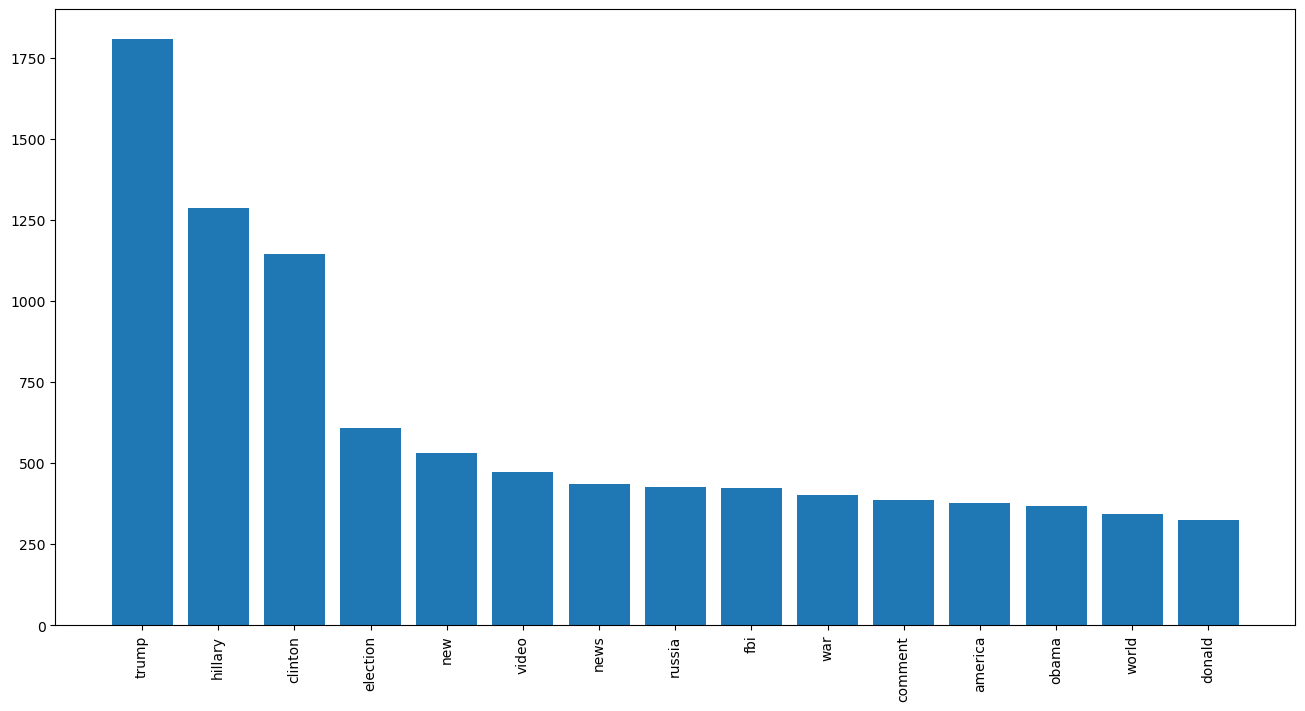

In [17]:
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(15), frequency[top_words[::-1][:15]])
ax.set_xticks(range(15))
ax.set_xticklabels(vocabulary[top_words[::-1][:15]], rotation='vertical')
plt.show()

In [18]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

In [19]:
n_topics = 8
lsa = TruncatedSVD(n_components = n_topics)
lsa_topics = lsa.fit_transform(Bow)

In [21]:
print(lsa_topics.shape)
print(lsa.components_.shape)

(12999, 8)
(8, 17447)


In [23]:
def most_common_words(n, vocabulary, topic_model):
    out = []
    for i, topic in enumerate(topic_model.components_):
        out.append([vocabulary[j] for j in topic.argsort()[:-n-1:-1]])
    return out

In [24]:
words = most_common_words(8, vocabulary, lsa)
for i, topic in enumerate(words):
    print("Topic ", i+1, " : ", topic)

Topic  1  :  ['trump', 'hillary', 'clinton', 'donald', 'fbi', 'election', 'video', 'new']
Topic  2  :  ['hillary', 'clinton', 'fbi', 'emails', 'email', 'wikileaks', 'investigation', 'campaign']
Topic  3  :  ['clinton', 'news', 'new', 'america', 'russia', 'fbi', 'war', 'foundation']
Topic  4  :  ['news', 'election', 'america', 'russia', 'source', 'onion', 'finest', 'new']
Topic  5  :  ['election', 'video', 'day', '2016', 'new', 'presidential', 'fbi', 'obama']
Topic  6  :  ['new', 'war', 'world', 'russia', 'fbi', 'comment', 'video', 'investigation']
Topic  7  :  ['war', 'russia', 'world', '2016', 'clinton', 'election', 'syria', 'syrian']
Topic  8  :  ['video', 'news', 'obama', 'watch', 'truthfeed', 'says', 'russia', 'comment']


In [25]:
lda = LatentDirichletAllocation(n_components = n_topics)
lda_topics = lda.fit_transform(Bow)

In [26]:
words = most_common_words(8, vocabulary, lda)
for i, topic in enumerate(words):
    print("Topic ", i+1, " : ", topic)

Topic  1  :  ['trump', 'donald', 'video', 'syria', 'war', 'new', 'aleppo', 'russia']
Topic  2  :  ['trump', 'new', 'fake', 'news', 'right', '11', 'world', '16']
Topic  3  :  ['dakota', 'pipeline', 'trump', 'police', 'access', 'protesters', 'water', 'obamacare']
Topic  4  :  ['world', 'election', 'war', 'america', 'russia', 'le', 'russian', 'gorafi']
Topic  5  :  ['russia', 'comment', 'trump', 'white', 'house', 'hillary', 'nato', 'putin']
Topic  6  :  ['hillary', 'clinton', 'trump', 'election', 'fbi', 'emails', 'wikileaks', 'email']
Topic  7  :  ['states', 'day', 'united', 'russia', 'america', 'comment', 'gold', 'world']
Topic  8  :  ['news', 'trump', 'america', 'new', 'source', 'onion', 'finest', '2016']


## 2 - Dense Representations 

### Word Embeddings : Distributed representations via the distributional hypothesis 

**Goal**: We will try to obtain dense representations (as vectors of real numbers) of words (and possibly sentences). These representations are intended to be distributed: they are non-local representations. We represent an object as a combination of *features*, as opposed to the attribution of a dedicated symbol: see the founding work of Geoffrey Hinton, among others, on the subject: [Distributed Representations](https://web.stanford.edu/~jlmcc/papers/PDP/Chapter3.pdf).

The term *distributed* representations is very general, but is what we are looking for. The challenge is therefore to be able to build, automatically, such representations.

**Underlying idea**: It is based on the distributional hypothesis: contextual information is sufficient to obtain a viable representation of linguistic objects.
 - For a large class of cases [...] the meaning of a word is its use in the language." Wittgenstein (Philosophical Investigations, 43 - 1953)
 - You shall know a word by the company it keeps, Firth.

Thus, a word can be characterized by the words that accompany it, via co-occurrence counts. Two words with a similar meaning will have a similar contextual distribution and are therefore more likely to appear in similar contexts. This hypothesis can be used as a justification for the application of statistics to semantics (information extraction, semantic analysis). It also allows some form of generalization: we can assume that the information we have about a word will be generalized to words with a similar distribution. 

**Motivation**: The goal is to obtain distributed representations in order to be able to effectively**:
- Directly perform a semantic surface analysis.
- Use it as a source of information for other language-related models and applications, especially for sentiment analysis. 


**Terminology**: Be careful not to confuse the idea of *distributed* and *distributional* representation. The latter generally indicates (for words) that the representation has been obtained strictly from co-occurrence counts, whereas additional information (document labels, part of speech tags, ...) can be used to build distributed representations. 
The models that allow to build these dense representations, in the form of vectors, are often called *vector spaces models*. These representations are also regularly called *word embeddings*, because the words are embedded in a vector space. In French, we often find the term *word embedding* or *lexical embedding*.

### Getting representations: counts of occurrences and co-occurrences

Depending on the type of corpus available, different types of distributional information can be obtained. If we have access to a collection of documents, we can thus choose to count the number of occurrences of each word in each document, to obtain a $words \times documents$ matrix: it is on this principle that **Tf-Idf** is built. We will now look at a more general case: we have a large amount of data in text form, and we want to obtain representations of words in the form of vectors of reduced size, without the need to divide them into documents or categories. 

Suppose we have a corpus containing $T$ different words. We will construct a $\mathbf{M}$ matrix of size $T \times T$ which will contain the number of co-occurrences between words. There will be different factors to consider when constructing this matrix: 

- How do you define the 'context' of a word - context which will tell you what terms co-occur with that word?

We can choose to use different scales: the document, the sentence, the nominal group, or simply a window of $k$ words, depending on the information we want to capture.


- How do we quantify the importance of the counts? 

$\rightarrow$ For example, we can give a decreasing weight to a co-occurrence according to the distance between the two words concerned ($\frac{1}{d+1}$ for a separation by $d$ words).


- Should we keep all the words that appear in the corpus? 

$\rightarrow$ Usually not. We will see that for large corpora, the number $T$ of different words is huge. Second, even if the number of words is reasonable, we will have very little distributional information on the rarest words, and the representation obtained will be of poor quality. We will have to ask ourselves how to filter these words, and how to treat the words we choose not to represent.  

#### Example:

Let's look at the following text:

*I walked down down the boulevard. I walked down the avenue. I ran down the boulevard. I walk down the city. I walk down the the avenue.*

We choose to define the context of a word as the sentence to which it belongs, and to not use any weighting.
We obtain the following matrix: 

|     *         | I | the | down | walked | boulevard | avenue | walk | ran | city |
|---------------|---|-----|------|--------|-----------|--------|------|-----|------|
| I             | 0 |      6 |    6 |   2 |         2 |      2 |   2 |    1 |    1 |
| the           | 6 |      2 |    7 |   2 |         2 |      3 |   3 |    1 |    1 |
| down          | 6 |      7 |    2 |   3 |         3 |      2 |   2 |    1 |    1 |
| walked        | 2 |      2 |    3 |   0 |         1 |      1 |   0 |    0 |    0 |
| boulevard     | 2 |      2 |    3 |   1 |         0 |      0 |   0 |    1 |    0 |
| avenue        | 2 |      3 |    2 |   1 |         0 |      0 |   1 |    0 |    0 |
| ran           | 2 |      3 |    2 |   0 |         0 |      1 |   0 |    0 |    1 |
| walk          | 1 |      1 |    1 |   0 |         1 |      0 |   0 |    0 |    0 |
| city          | 1 |      1 |    1 |   0 |         0 |      0 |   1 |    0 |    1 |

### 3.A In practice: get a Vocabulary.

To begin, we will implement separately a function returning the vocabulary. Here we will have to be able to control its size, by indicating a maximum number of words.

**Remarks:**
- We add a special token ```<UNK>``` to deal with out-of-vocabulary words: even if you don't put a limit, you might encounter new words when working with new data. 
- We need to count words and sort them by frequency in order to only keep the most frequent ones. It is not necessary to count 'unknown' words.

In [27]:
from nltk import word_tokenize

def vocabulary(corpus, voc_threshold=0):
    """    
    Function using word counts to build a vocabulary - can be improved with a second parameter for 
    setting a frequency threshold
    Params:
        corpus (list of list of strings): corpus of sentences
        voc_threshold (int): maximum size of the vocabulary (0 means no limit !)
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency        
    """
    stop_words = sklearn.feature_extraction.text.ENGLISH_STOP_WORDS
    
    word_counts = {}
    for sent in corpus:
        for word in [word.lower() for word in word_tokenize(sent) if word.isalpha()]:
            if (word not in stop_words):
                if (word not in word_counts):
                    word_counts[word] = 0
                word_counts[word] += 1           
    words = sorted(word_counts.keys(), key=word_counts.get, reverse=True)
    if voc_threshold > 0:
        words = words[:voc_threshold] + ['UNK']   
    vocabulary = {words[i] : i for i in range(len(words))}
    return vocabulary, {word: word_counts.get(word, 0) for word in vocabulary}

In [28]:
# Example for testing:
corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']

voc, counts = vocabulary(corpus)
print(voc)
print(counts)

{'walked': 0, 'boulevard': 1, 'avenue': 2, 'walk': 3, 'ran': 4, 'city': 5}
{'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1}


### 2.B Obtaining co-occurences:

The function takes as input the corpus (a list of strings, corresponding to documents/sentences) and a vocabulary, as well as the size of the context window. We can also implement the simplest solution: the context of a word being the full document to which it belongs. 
Finally, we can implement the possibility of making linearly decrease the importance of the context of a word when getting further from the input word.

**Remark:**
- The matrix we are building is symmetric: we can only build half of it !

In [29]:
def co_occurence_matrix(corpus, vocabulary, window=0, distance_weighting=False):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
        distance_weighting (bool): indicates if we use a weight depending on the distance between words for co-oc counts
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-oc matrix, using the same ordering as the vocabulary given in input    
    """ 
    stop_words = sklearn.feature_extraction.text.ENGLISH_STOP_WORDS
    l = len(vocabulary)
    M = np.zeros((l,l))
    for sent in corpus:
        # Get the sentence
        sent = [word.lower() for word in word_tokenize(sent) if word.isalpha()]
        # Obtain the indexes of the words in the sentence from the vocabulary 
        sent_idx = [vocabulary.get(word, len(vocabulary)-1) for word in sent if (word not in stop_words)]
        # Avoid one-word sentences - can create issues in normalization:
        if len(sent_idx) == 1:
                sent_idx.append(len(vocabulary)-1)
        # Go through the indexes and add 1 / dist(i,j) to M[i,j] if words of index i and j appear in the same window
        for i, idx in enumerate(sent_idx):
            # If we consider a limited context:
            if window > 0:
                # Create a list containing the indexes that are on the left of the current index 'idx_i'
                l_ctx_idx = [sent_idx[j] for j in range(max(0,i-window),i)]                
            # If the context is the entire document:
            else:
                # The list containing the left context is easier to create
                l_ctx_idx = sent_idx[:i]
            # Go through the list and update M[i,j]:        
            for j, ctx_idx in enumerate(l_ctx_idx):
                if distance_weighting:
                    weight = 1.0 / (len(l_ctx_idx) - j)
                else:
                    weight = 1.0
                M[idx, ctx_idx] += weight * 1.0
                M[ctx_idx, idx] += weight * 1.0
    return M  

In [30]:
print(co_occurence_matrix(corpus, voc, 0, False))
# Results will differ from the above example because the vocabulary and the order of words are not 
# necessarily the same ! 

[[0. 1. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


### 2.C Application to our dataset

#### Quick study of the data

We'll get the vocabulary (in full) and represent the frequencies of the words, in order: we should find back Zipf's law. This will give us an idea of the size of the vocabulary we will be able to choose: it's a matter of making a compromise between the necessary resources (size of the objects in memory) and the amount of information we can get from them (rare words can bring a lot of information, but it's difficult to learn good representations of them, because they are rare!).  

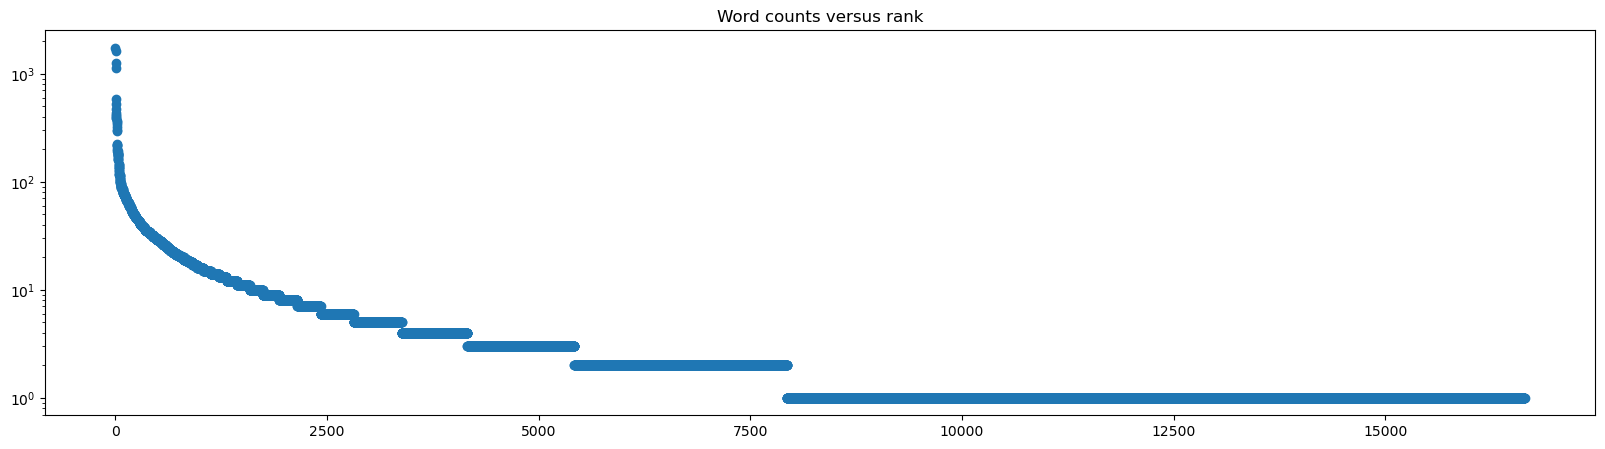

Vocabulary size: 16648
Part of the corpus by taking the "x" most frequent words:
2000 : 0.68
4000 : 0.80
6000 : 0.86
8000 : 0.90
10000 : 0.93
12000 : 0.95
14000 : 0.97
16000 : 0.99


In [24]:
vocab, word_counts = vocabulary(texts)
rank_counts = {w:[vocab[w], word_counts[w]] for w in vocab}
rank_counts_array = np.array(list(rank_counts.values()))

plt.figure(figsize=(20,5))
plt.title('Word counts versus rank')
plt.scatter(rank_counts_array[:,0], rank_counts_array[:,1])
plt.yscale('log')
plt.show()

print('Vocabulary size: %i' % len(vocab))
print('Part of the corpus by taking the "x" most frequent words:')
for i in range(2000, len(vocab), 2000):
    print('%i : %.2f' % (i, np.sum(rank_counts_array[:i, 1]) / np.sum(rank_counts_array[:,1]) ))

**Result of the analysis**: we can be satisfied with a vocabulary of 4,000 - this is important, because it will determine the size of the objects we will manipulate. 

In [31]:
vocab, word_counts = vocabulary(texts, 4000)

In [32]:
print(vocab['american'])

33


#### Obtaining the matrices:
We can now get the co-occurence matrices with parameters of our choosing.

In [33]:
M = co_occurence_matrix(texts, vocab, window=5, distance_weighting=False)
print(M.shape)

(4001, 4001)


### 2.D Vector comparison 

We can use these very large-dimensional vectors for a very simple semantic analysis: for example, by looking for the nearest neighbors of a words. However, we need to be careful to the distance that we use (euclidean, cosine). Vector normalization can also play a role; in any way, we need to not over-interpret this type of results. 

In [34]:
def euclidean(u, v):
    return np.linalg.norm(u-v)

def length_norm(u):
    return u / np.sqrt(u.dot(u))

def cosine(u, v):
    return 1.0 - length_norm(u).dot(length_norm(v))

from sklearn.neighbors import NearestNeighbors

def print_neighbors(distance, voc, co_oc, mot, k=10):
    inv_voc = {id: w for w, id in voc.items()}
    neigh = NearestNeighbors(n_neighbors=k, algorithm='brute', metric=distance)
    neigh.fit(co_oc) 
    dist, ind = neigh.kneighbors([co_oc[voc[mot]]])
    print("Plus proches voisins de %s selon la distance '%s': " % (mot, distance.__name__))
    print([[inv_voc[i] for i in s[1:]] for s in ind])
    
print_neighbors(euclidean, vocab, M, 'american')
print_neighbors(cosine, vocab, M, 'american')

Plus proches voisins de american selon la distance 'euclidean': 
[['life', 'like', 'и', 'que', 'rt', 'y', 'time', 'muslim', 'say']]
Plus proches voisins de american selon la distance 'cosine': 
[['people', 'comment', 'UNK', 'video', 's', 'time', 'man', 'said', 'media']]


#### Vector re-weighting:

Similarly as before, we may want to alter the representations to obtain better features - depending on what use we will have for them.

**Normalization**: Very easy: we want to cancel the influence of the magnitude of the counts on the representation.

$$\mathbf{m_{normalized}} = \left[ 
   \frac{m_{1}}{\sum_{i=1}^{n}m_{i}}, 
   \frac{m_{2}}{\sum_{i=1}^{n}m_{i}}, 
   \ldots
   \frac{m_{n}}{\sum_{i=1}^{n}m_{i}}, 
\right]$$
 
**Pointwise Mutual Information**: The aim is to assess the extent to which the co-occurrence of the two terms is *unexpected*. This measure is the ratio of the joint probability of the two words and the product of their individual probabilities:
$$
\text{PMI}(x,y) = \log \left( \frac{P(x,y)}{P(x)P(y)} \right)
$$
The joint probability of the two words corresponds to the number of times they are observed together, divided by the total number of co-occurrences in the corpus: 
$$ P(\mathbf{M},w_{1},w_{2}) = \frac{M_{w_{1},w_{2}}}{\sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j}} $$
The individual probability of a word simply corresponds to its frequency, which can be calculated by counting all co-occurrences where that word appears:
$$ P(\mathbf{M},w) = \frac{\sum_{j=1}^{m} M_{w,j}}{\sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j}} $$
Hence,
$$ 
\text{PMI}(\mathbf{M},w_{1},w_{2}) = \log  \frac{M_{w_{1},w_{2}} \times \left( \sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j} \right)}{\left( \sum_{j=1}^{n} M_{w_{1},j} \right) \times \left( \sum_{i=1}^{n}M_{i,w_{2}} \right)} 
$$
We thus calculate the discrepancy between the observation we have made in our corpus and the frequency of appearance of these terms if we consider them independent - i.e. we assume that their co-occurrence is a coincidence.

The main problem with this measure is that it is not adapted to the case where no co-occurrence is observed. Since the PMI is supposed to return a positive quantity if more co-occurrences are observed than expected, and a negative quantity if fewer co-occurrences are observed, we cannot choose to replace $\log(0)$ by $0$. A commonly used solution is to use the **Positive PMI**, which sets all negative values to $0$.
 
 $$ \text{PPMI}(\mathbf{M},w_{1},w_{2}) = 
 \begin{cases}
 \text{PMI}(\mathbf{M},w_{1},w_{2}) & \textrm{if } \text{PMI}(\mathbf{M},w_{1},w_{2}) > 0 \\
 0 & \textrm{otherwise}
 \end{cases} $$

In [35]:
def pmi(co_oc, positive=True):
    sum_vec = co_oc.sum(axis=0)
    sum_tot = sum_vec.sum()
    with np.errstate(divide='ignore'):
        pmi = np.log((co_oc * sum_tot) / (np.outer(sum_vec, sum_vec)))                   
    pmi[np.isinf(pmi)] = 0.0  # log(0) = 0
    if positive:
        pmi[pmi < 0] = 0.0
    return pmi

In [36]:
PPMI = pmi(M)

print("Avec la PPMI:")    
print_neighbors(euclidean, vocab, PPMI, 'american')
print_neighbors(cosine, vocab, PPMI, 'american')

Avec la PPMI:
Plus proches voisins de american selon la distance 'euclidean': 
[['newsticker', 'gaiaportal', 'cooler', 'في', 'кто', 'perfection', 'owes', 'hybrid', 'к']]
Plus proches voisins de american selon la distance 'cosine': 
[['lookout', 'herald', 'people', 'native', 'tribune', 'new', 'trump', 'government', 'buffalo']]


### 2.E Word representations through count-based methods: reducing the dimension of co-occurence matrices

#### Motivation

The goal is not only to reduce the size of the data representation but also showcase higher-level relationships between words: by reducing their representations to the *most important dimensions* of the data, we end up *generalizing* some properties of words.

#### Dimension reduction via SVD 

A matrix is a linear transformation: applying a SVD to it is decomposing our linear transformation in a product of linear transformations of different types. We are changing the basis and replacing our data in a different space, using **eigenvectors**:

$$ \mathbf{M} = \mathbf{U} \mathbf{\lambda} \mathbf{V}^{\text{T}} $$

Matrices $\mathbf{U}$, $\mathbf{\lambda}$, and $\mathbf{V}$ have the following properties:
- $\mathbf{U}$ and $\mathbf{V}$ are orthogonal matrices ($\mathbf{U}^{\text{T}} = \mathbf{U}^{-1}$ and $\mathbf{V}^{\text{T}} = \mathbf{V}^{-1}$). They contain the eingenvectors to the left and to the right of $\mathbf{M}$.
- $\mathbf{\lambda}$ is a diagonal matrix: careful, it is not necessarily square. diagonal coefficient are the eigenvalues of $\mathbf{M}$.

Then, the *most important dimensions* correspond to the highest eigenvalues. Reducing our data to a dimension $k$ corresponds to only keeping vectors corresponding to the $k$ first eigenvalues - which in turns is equivalent to keeping only the first $k$ vectors of $U$. 
We use ```TruncatedSVD``` from ```scikit-learn```:

In [37]:
svd = TruncatedSVD(n_components=300)
SVDEmbeddings = svd.fit_transform(M)
print(SVDEmbeddings.shape)
SVDEmbeddings[vocab['UNK']]

print_neighbors(euclidean, vocab, SVDEmbeddings, 'american')
print_neighbors(cosine, vocab, SVDEmbeddings, 'american')

(4001, 300)
Plus proches voisins de american selon la distance 'euclidean': 
[['life', 'like', 'rt', 'que', 'и', 'time', 'y', 'muslim', 'say']]
Plus proches voisins de american selon la distance 'cosine': 
[['people', 'comment', 'UNK', 'video', 'said', 'poor', 'time', 'called', 'meet']]


In [38]:
svd_ppmi = TruncatedSVD(n_components=300)
SVDPPMIEmbeddings = svd_ppmi.fit_transform(PPMI)
print(SVDPPMIEmbeddings.shape)
SVDPPMIEmbeddings[vocab['UNK']]

print_neighbors(euclidean, vocab, SVDPPMIEmbeddings, 'american')
print_neighbors(cosine, vocab, SVDPPMIEmbeddings, 'american')

(4001, 300)
Plus proches voisins de american selon la distance 'euclidean': 
[['herald', 'lookout', 'tribune', 'flags', 'peoples', 'changed', 'author', 'sit', 'brandon']]
Plus proches voisins de american selon la distance 'cosine': 
[['herald', 'lookout', 'tribune', 'native', 'flags', 'peoples', 'changed', 'author', 'sit']]


Note: When applying this method to the count matrix $\mathbf{M}$ of dimension $T \times D$, where $\mathbf{M}_{t,d}$ contains the number of occuerences of the word $t$ in the document $d$, we obtain the method called **Latent Semantic Analysis**, which is used to detect latent (semantic) components allowing to group documents together.

#### Visualization in two dimensions

We will now use **principal components analysis** (PCA) to visualize our data in two dimensions. This is equivalent to applying SVD to the covariance matrix of the data, in order for the principal components to be independant from each other an maximize the variance of the data. We use the class ```PCA``` from ```scikit-learn```: 

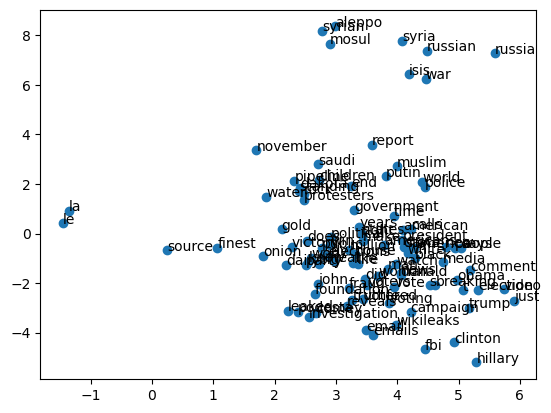

In [39]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)
Emb = pca.fit_transform(PPMI)

# Let's take the most frequent words
words = sorted(word_counts.keys(), key=word_counts.get, reverse=True)[:100]

ind_words = [vocab[w] for w in words]
x_words = [Emb[ind,0] for ind in ind_words]
y_words = [Emb[ind,1] for ind in ind_words]

fig, ax = plt.subplots()
ax.scatter(x_words, y_words)

for i, w in enumerate(words):
    ax.annotate(w, (x_words[i], y_words[i]), (x_words[i] + 0.001, y_words[i] + 0.001))

### 2.F Word representations through prediction-based methods

The idea here is to define a set of representations ${w_{i}}_{i=1}^{V}$, of predefined dimension $d$ (here, we will work with $d = 300$), for all the words $i$ of the vocabulary $V$ - then **train** these representations to match what we want. 

#### Glove

The objective defined by Glove ([Pennington et al. (2014)](http://www.aclweb.org/anthology/D/D14/D14-1162.pdf)) is to learn from the vectors $w_{i}$ and $w_{k}$ so that their scalar product corresponds to the logarithm of their **Pointwise Mutual Information**: 


$$ w_{i}^\top w_{k} = (PMI(w_{i}, w_{k}))$$


In the article, this objective is carefully justified by a reasoning about the operations one wants to perform with these vectors and the properties they should have - in particular, symmetry between rows and columns (see the article for more details).  
The final goal obtained is the following, where $M$ is the co-occurrence matrix:


$$\sum_{i, j=1}^{|V|} f\left(M_{ij}\right)
  \left(w_i^\top w_j + b_i + b_j - \log M_{ij}\right)^2$$
  
 
Here, $f$ is a *scaling* function that reduces the importance of the most frequent co-occurrence counts: 


$$f(x) 
\begin{cases}
(x/x_{\max})^{\alpha} & \textrm{if } x < x_{\max} \\
1 & \textrm{otherwise}
\end{cases}$$


Usually, we choose $\alpha=0.75$ and $x_{\max} = 100$, although these parameters may need to be changed depending on the data.

The following code uses the gensim API to retrieve pre-trained representations (It is normal that the loading is long).

In [40]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")

We can extract the embedding matrix this way, and check its size:

In [35]:
loaded_glove_embeddings = loaded_glove_model.vectors
print(loaded_glove_embeddings.shape)

(400000, 300)


We can see that there are $400,000$ words represented, and that the embeddings are of size $300$. We define a function that returns, from the loaded model, the vocabulary and the embedding matrix according to the structures we used before. We add, here again, an unknown word "UNK" in case there are words in our data that are not part of the $400,000$ words represented here. 

In [36]:
def get_glove_voc_and_embeddings(glove_model):
    voc = {word : index for index, word in enumerate(glove_model.index_to_key)}
    voc['UNK'] = len(voc)
    embeddings = glove_model.vectors
    return voc, embeddings

In [37]:
loaded_glove_voc, loaded_glove_embeddings = get_glove_voc_and_embeddings(loaded_glove_model)

In order to compare the representations loaded here and the ones produced with word2vec, the same vocabulary should be used. For this purpose, I reuse the following code to create a $5000$ word vocabulary from the data, and I add at the end a function that returns the matrix of representations loaded with Glove for these $5000$ words only, in the right order. 

In [38]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.key_to_index.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc),glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

In [39]:
GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, vocab)

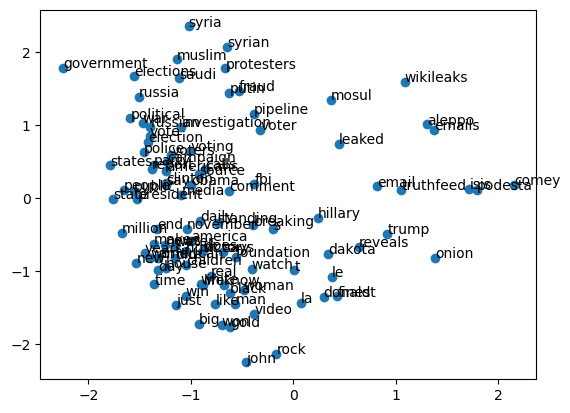

In [40]:
pca = PCA(n_components=2, whiten=True)
Emb = pca.fit_transform(GloveEmbeddings)

# Let's take the most frequent words
words = sorted(word_counts.keys(), key=word_counts.get, reverse=True)[:100]

ind_words = [vocab[w] for w in words]
x_words = [Emb[ind,0] for ind in ind_words]
y_words = [Emb[ind,1] for ind in ind_words]

fig, ax = plt.subplots()
ax.scatter(x_words, y_words)

for i, w in enumerate(words):
    ax.annotate(w, (x_words[i], y_words[i]), (x_words[i] + 0.001, y_words[i] + 0.001))

Let's now try to look at general purpose glove representations:

In [41]:
pca = PCA(n_components=2, whiten=True)
Emb = pca.fit_transform(loaded_glove_embeddings)

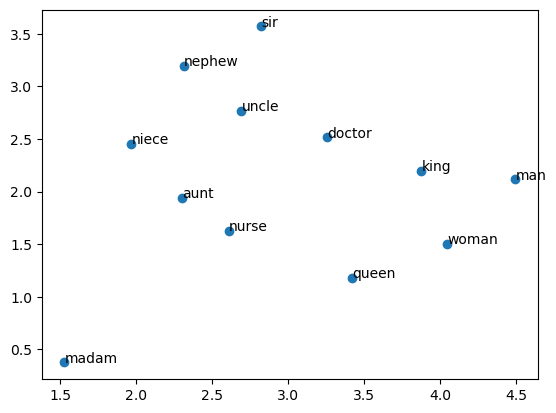

In [42]:

# Let's look at some words
words = ['man', 'woman', 'king', 'queen', 'doctor','nurse', 'uncle','aunt','niece','nephew','sir','madam']

ind_words = [loaded_glove_voc[w] for w in words]
x_words = [Emb[ind,0] for ind in ind_words]
y_words = [Emb[ind,1] for ind in ind_words]

fig, ax = plt.subplots()
ax.scatter(x_words, y_words)

for i, w in enumerate(words):
    ax.annotate(w, (x_words[i], y_words[i]), (x_words[i] + 0.001, y_words[i] + 0.001))

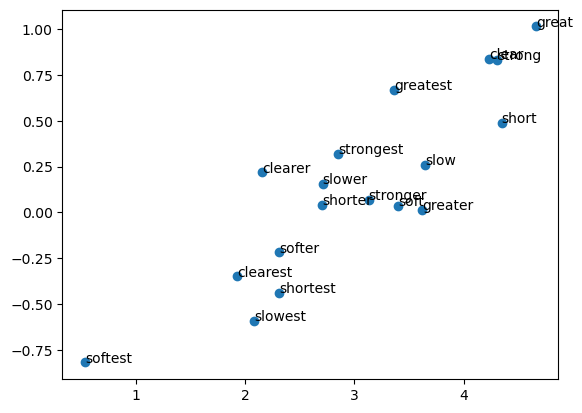

In [43]:
# Let's look at some words
words = ['slow', 'slower', 'slowest',
         'short', 'shorter','shortest',
         'strong','stronger','strongest',
         'clear','clearer','clearest',
         'soft', 'softer', 'softest',
         'great', 'greater', 'greatest']

ind_words = [loaded_glove_voc[w] for w in words]
x_words = [Emb[ind,0] for ind in ind_words]
y_words = [Emb[ind,1] for ind in ind_words]

fig, ax = plt.subplots()
ax.scatter(x_words, y_words)

for i, w in enumerate(words):
    ax.annotate(w, (x_words[i], y_words[i]), (x_words[i] + 0.001, y_words[i] + 0.001))